### Tracking Vehicles Using Machine Learning and Computer Vision
Udacity Self-Driving Car Engineer Nanodegree
By Leotis Buchanan

---

**Vehicle Detection Project**

The goals / steps of this project were:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Normalize the features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how  you extracted HOG features from the training images.

Hog features was extracted from all channels of the input images

My implementation read in all vehicles and non-vehicles from the data folder. The hog features was then computed using 
"skimage.feature.hog function. All hog features for all three channels of the input images were calculate.They were then concatenated to form single feature vector.

Below are examples of a vehicle and a non vehicle image that was used.

#### Vehicle
<img src='data/cars/312.jpeg' alt="Mountain View" style="width:304px;height:228px;">


#### Non Vehicle
<img src='data/notcars/image0249.jpeg' alt="Not Cars" style="width:304px;height:228px;">
 

I then built the classifier with various color spaces and hog parameters. Based on the accuracy of the classify on the test set I chosed the following parameters: 

- orientation:8 
- pixels_per_cell = 8, 8
- cells_per_block = 2,2 
- color space YCrCb

The below are images of the computed HOG features for vehicle images and a non vehicle images

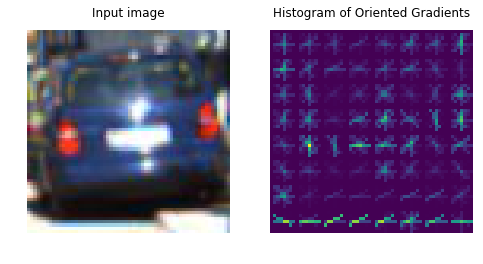

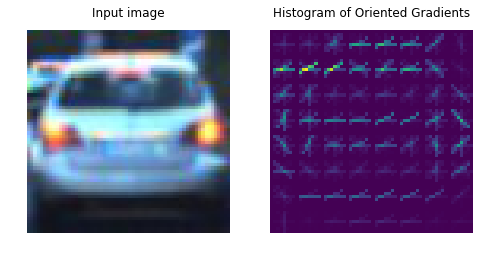

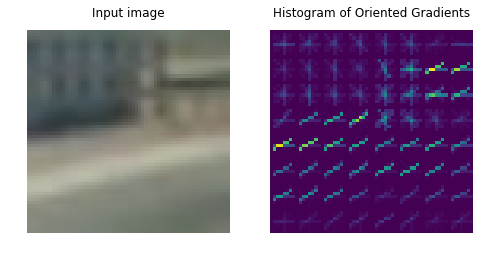

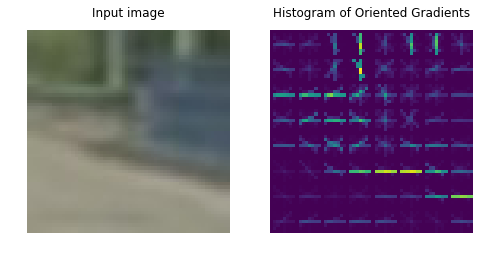

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from skimage import data, color, exposure

def display(path):
    image = mpimg.imread(path)
    img_channel = image[:, :, 0]
    fd, hog_image = hog(img_channel, orientations=8, pixels_per_cell=(8, 8),
                     cells_per_block=(1, 1), visualise=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

    ax2.axis('off')
    ax2.imshow(hog_image)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()
    
path = 'data/cars/340.jpeg'
display(path)

path = 'data/cars/341.jpeg'
display(path)

path = 'data/notcars/image0087.jpeg'
display(path)

path = 'data/notcars/image0088.jpeg'
display(path)

The code used to compute the hog features is shown in the cell below. It is implemented in the file featuregenerator.py starting from line 14.  

In [ ]:
def generate_hog_features(self, feature_image, orient,
                            pix_per_cell, cell_per_block,
                            hog_channel=0,
                            vis=False,
                            feature_vec=True):

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                img_channel = feature_image[:, :, channel]
                features = hog(img_channel, orientations=orient,
                               pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block,
                                                cell_per_block),
                               transform_sqrt=True,
                               visualise=vis, feature_vector=feature_vec)
                hog_features.extend(features)

        else:
            img_channel = feature_image[:, :, hog_channel]
            hog_features = hog(img_channel, orientations=orient,
                               pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block,
                                                cell_per_block),
                               transform_sqrt=True,
                               visualise=vis, feature_vector=feature_vec)

        return hog_features

#### 2. Explain how you settled on your final choice of HOG parameters.

I varied the paramaters and observed thier effect on the accuracy of the classifier. The parameters that resulted in the best classifier were selected.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The training of the classifier was done in a seperate class. This class is called ModelTrainer.  It is implemented in the file modelTrainer.py. It uses the FeatureGenerator class to generate the features required to train the model.


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

All window related functions were implemented in the WindowManager class. This class can be found in the windowManager.py file. 

I observed that size of the cars in project video, was typically 200 x 150 to about 64 x 64. Additionally my training data had images that were 64 x 64. It was based on this and also the requirement that my search was not too slow, that I decided to use window sizes of 200 x 150, 150 x 100 and 64 x 64. 
The image in the cell below shows the selected windows. 

The method that performs the window search is shown in the cell below:

```python
def search_windows(self, img, windows, classifier,
                       featureGenerator, settingsDict):

        on_windows = []
        # 2) Iterate over all windows in the list
        for window in windows:
            # 3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1],
                                      window[0][0]:window[1][0]], (64, 64))
            # 4) Extract features for that window using single_img_features()
            features = featureGenerator.getAllFeatures(test_img, settingsDict)
            # 5) Scale extracted features to be fed to classifier

            test_features = np.array(features).reshape(1, -1)
            # 6) Predict using your classifier

            decision = classifier.decision_function(test_features)
            prediction = int(decision > 0)
            if prediction == 1:
                print("decision:" , decision)
                on_windows.append(window)
        # 8) Return windows for positive detections
        return on_windows
```        

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

In order to optimize my pipeline I ensure that I was not searching the entire image. Instead I search just where cars are expected to be.


The images below shows examples of the pipeline working:

#### Example 1
<img src='writeup_images/image0.png' alt="Mountain View" style="width:600px;height:600px;">


#### Example 2
<img src='writeup_images/image1.png' alt="Mountain View" style="width:600px;height:600px;">


#### Example 3
<img src='writeup_images/image2.png' alt="Mountain View" style="width:600px;height:600px;">

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here is the [link to my video result](https://github.com/LeotisBuchanan/udacity_vehicle_detection/blob/master/videos/output/project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

#### Detecting false positives

open cv dilate blobs, merge blobs as one

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:


#### Combining overlapping boxes[working on this now]

My approach for combining overlapping boxes is shown on line  77 of predictionQualityManager.py file



### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

<img src='heatmap.jpg' alt="" style="width:600px;height:600px;">

<img src='image.jpg' alt="" style="width:600px;height:600px;">


### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

#### Problems:
- Throughout this term, my major problem was getting time to work on these projects, this severly affected the quality of
  my submissions.
- Most of the code was provided by the instructor, this posed a problem for me, because once i read code, it affected
  my ability to come up with an independent solution.


#### Where will your pipeline likely fail?

I dont think the approach taken in this project is very robust. Our approach could be made to fail by a picture
of a car on a wall or the back of a truck. Also it is dependent on vehicles have markings/edges that are different
from other objects in the camera view. This is not very robust or future prove, because if a vehicle looks like non-cars
then it will not be classified as a car. We did not address ambient lighting, like glare from head lamps, or no lighting,
cars without headlamps driving in the night(yes it does happen :-))


What could you do to make it more robust?
The approach taken in this project, does not allow the system to really understand what a vehicle is. Incoperating other features of a vehicle such:
- its on the road,
- its behavior it is moving
- it structure i.e it has wheels
- other characteristics that humans use to determine that a vehicle is a vehicle.


The algorithm used assumes laboratory like conditions, i.e
- the lighting is at a particular level
- the images possess particular features
- it did not take in account other types of vehicles, trucks, bicycles, motor cycles 